<a href="https://colab.research.google.com/github/engige/nlp_consumer_complaints_classification/blob/main/index_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Customer Complaints Classification

## Project Overview (Draft)

This project leverages Natural Language Processing (NLP) techniques to automatically classify customer complaints. By training an NLP model to understand the content of complaints, the system can reduce the number of questions customers need to answer before submitting their issues. The primary goals are:

1. To minimize the time customers spend logging complaints by reducing the number of survey questions.
2. To create a user-friendly platform that allows customers to quickly submit their complaints or feedback.

Objectives:

* Train an NLP model to automatically classify consumer complaints into predefined categories based on their content.
* Enhance the customer complaint logging experience by streamlining the complaint submission process.
* Improve financial institutions' responsiveness by providing faster, more accurate categorization of complaints.

This project will explore the use of machine learning models such as text classification algorithms, potentially including logistic regression, support vector machines, or neural networks, combined with advanced NLP techniques like TF-IDF and word embeddings to understand the nature of customer complaints effectively.

## Business Understanding

**Problem Statement**:

Customers of financial institutions often experience significant frustration and dissatisfaction when lodging complaints related to financial services. The existing complaint submission processes typically involve navigating through multiple selection options or answering a series of questions generated by chatbots. This complexity not only prolongs the time required to submit a complaint but also adds to customer frustration, especially when timely resolution is critical. There is a pressing need for a faster and more efficient method for customers to lodge complaints without the burden of excessive questioning.

**Root Causes**:

* **Complex Navigation Structures:** Current platforms require customers to traverse numerous menus and options, making the submission process cumbersome.

* **Inefficient Chatbot Interactions:** Chatbots often generate redundant or irrelevant questions, leading to extended interaction times and increased customer irritation.

* **Lack of Personalization:** The absence of tailored pathways for different types of complaints results in a one-size-fits-all approach that does not address specific customer needs effectively.

* **Inadequate Data Utilization:** Existing systems may not fully leverage customer data to streamline the complaint submission process, leading to repetitive information requests.

**Key stakeholders:**

**1. Customers:** Play a crucial role in submitting complaints and providing feedback regarding financial services. They are primarily interested in seeking a quick and hassle-free method to lodge complaints and receive timely resolutions. To achieve this, customers require an intuitive and straightforward complaint submission interface that minimizes the number of steps and questions needed to lodge a complaint. Additionally, they seek assurance that their issues will be resolved promptly and effectively.

**2. Customer Service Support Teams:** Responsible for handling and resolving customer complaints efficiently. Their primary interest lies in managing and categorizing incoming complaints swiftly to expedite resolutions. To support these goals, they require simplified complaint categorization processes that speed up resolution times. Additionally, access to comprehensive and accurate complaint data is essential for effective management. Tools that allow them to track and monitor complaint statuses efficiently are also necessary to maintain high levels of service quality.

## Data Understanding

The Consumer Complaints Dataset from the Consumer Financial Protection Bureau (CFPB) provides a comprehensive source of real-world data on consumer grievances about various financial products and services. This dataset, accessible to the public, is particularly useful for natural language processing (NLP) projects, as it includes detailed narratives describing consumer complaints. These narratives cover disputes ranging from credit reporting issues to debt collection practices, providing a valuable foundation for developing an NLP model that can automatically classify and route complaints.

The dataset version we leveraged from kaggle includes thousands of consumer submissions categorized into five (5) financial product classes:

* Credit Reporting
* Debt Collection
* Mortgages and Loans (includes car loans, payday loans, student loans, etc.)
* Credit Cards
* Retail Banking (includes checking/savings accounts, as well as money transfers, etc.)


It consists of around 162,400 records, with narratives of varying lengths and detail. Although this categorization streamlined the data, it remains imbalanced, with 56% of complaints relating to credit reporting issues and the remaining categories ranging between 8% and 14%. This imbalance presents a challenge in building an effective model, requiring tailored strategies to ensure accurate and balanced classification across all categories.



## Data Exploration

In [ ]:
# Import necessary libraries
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define the path to the zip file and the CSV file inside it
zip_path = '/content/drive/MyDrive/data_comp.zip'
csv_filename = 'consumer_complaints.csv'

# Open the zip file and load the CSV file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open(csv_filename) as file:
        df = pd.read_csv(file)

# Display the first few raws of the dataframe
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [3]:
# Display basic information about the dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162421 non-null  int64 
 1   product     162421 non-null  object
 2   narrative   162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


The dataset has 162,421 entries and three columns:

1. **Unnamed: 0:** Appears to be an index column and can be ignored or removed.
2. **product:** Contains the complaint category (target variable) with values like credit_card, retail_banking, credit_reporting, etc.
3. **narrative:** Contains the text of each complaint.

Notably, the narrative column has 10 missing entries.

In [4]:
# Drop the unnecessary 'Unnamed: 0' column
df = df.drop(columns=['Unnamed: 0'])

# Drop rows with missing values in the 'narrative' column
df = df.dropna(subset=['narrative'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162411 entries, 0 to 162420
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   product    162411 non-null  object
 1   narrative  162411 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


Unncessary `Unnamed: 0` column dropped and missing values in `narrative` column handled.

In [5]:
# Check for duplicate rows based on 'product' and 'narrative' columns
duplicates = df.duplicated(subset=['product', 'narrative']).sum()

duplicates

37735

There are 37,735 duplicate entries in the dataset based on the product and narrative columns. However, we opted to keep them since during model selection and training, we noted that removing the duplicates negatively impacted our best model performance.

In [7]:
# Check the distribution of the 'product' categories
product_distribution = df['product'].value_counts()

product_distribution

,count
product,
credit_reporting,91172
debt_collection,23148
mortgages_and_loans,18990
credit_card,15566
retail_banking,13535


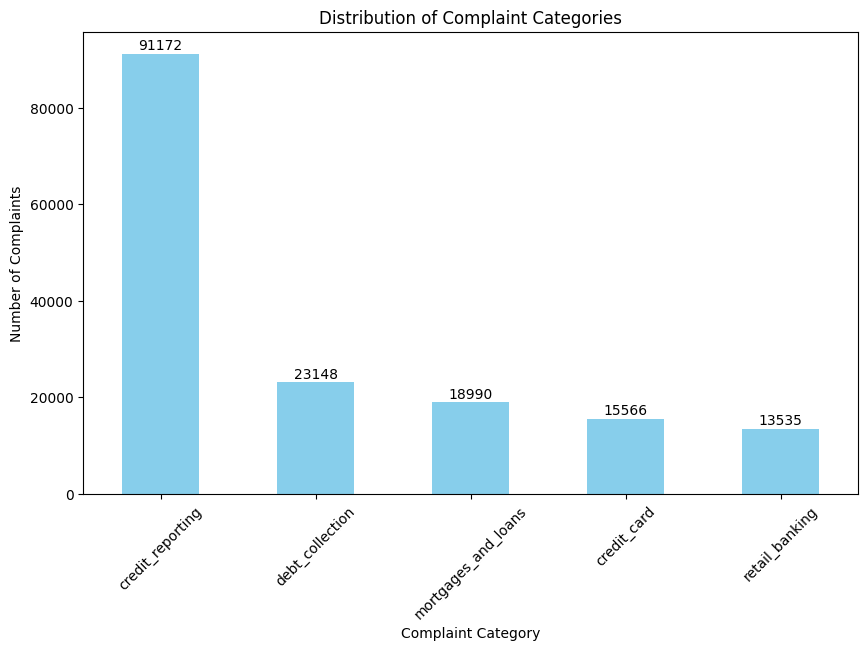

In [8]:
# Plot the distribution of complaint categories
plt.figure(figsize=(10, 6))
ax = product_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Complaint Categories')
plt.xlabel('Complaint Category')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)

# Add count on top of each bar
for i, count in enumerate(product_distribution):
    ax.text(i, count + 200, str(count), ha='center', va='bottom')

plt.show()

The distribution shows a class imbalance, with the credit_reporting category significantly more represented than others. We accounted for the imbalance through stratify parameter when separating the features and target to ensures that the class distribution in the training and testing sets matches that of the original dataset. Attempt to apply Synthetic Minority Oversampling Technique (SMOTE) didn't work due to memory resources limitation. However, the models performance was above average indicating that there was no need to perform further data balancing.

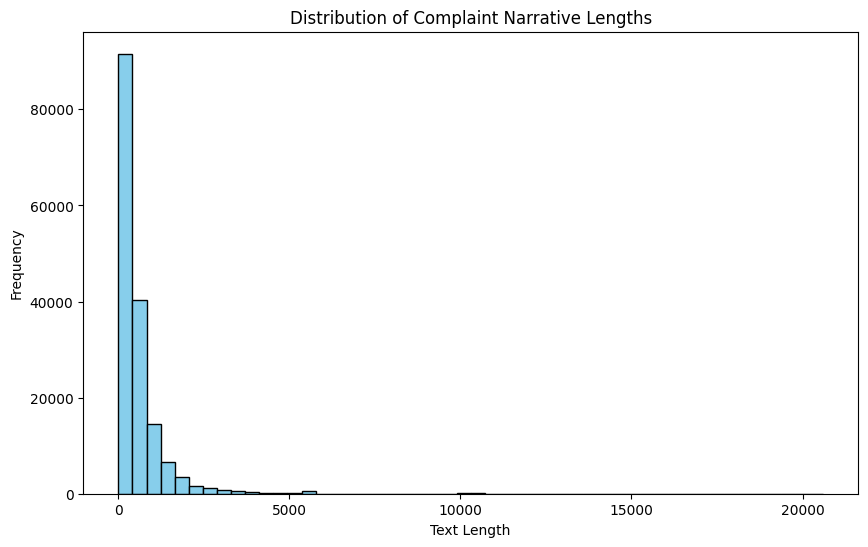

,text_length
count,162411.000000
mean,588.535838
std,830.977413
min,3.000000
25%,192.000000
50%,361.000000
75%,683.000000
max,20596.000000


In [9]:
# Check the length of the complaint narrative
# Calculate the length of each complaint narrative
df['text_length'] = df['narrative'].apply(len)

# Summary statistics for text length
text_length_summary = df['text_length'].describe()

# Plot the distribution of text length
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Complaint Narrative Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

text_length_summary

The histogram indicates a right-skewed distribution, with most narratives having fewer than 1,000 characters. This information is helpful for choosing an appropriate text processing approach and handling extremely short or long complaints if necessary.

## Data Preprocessing

In [10]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join words back into a single string with whitespace handling
    cleaned_text = ' '.join(words).strip()  # Remove leading/trailing whitespace
    return ' '.join(cleaned_text.split())    # Replace multiple spaces with a single space

# Apply preprocessing to the 'narrative' column
df['cleaned_narrative'] = df['narrative'].apply(preprocess_text)

# Display a sample of the cleaned narratives
df[['narrative', 'cleaned_narrative']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,narrative,cleaned_narrative
0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...
1,forwarded message date tue subject please inve...,forwarded message date tue subject please inve...
2,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...
3,payment history missing credit report speciali...,payment history missing credit report speciali...
4,payment history missing credit report made mis...,payment history missing credit report made mis...


Key Steps Included:

* **Lowercasing:** Ensures uniformity.
* **Removing Special Characters and Numbers:** Cleans up non-essential elements.
* **Tokenization:** Splits text into words.
* **Stop Word Removal:** Filters out common but non-informative words.
* **Lemmatization:** Reduces words to their root forms.
* **Whitespace Handling:** Trims leading/trailing whitespace and replaces multiple spaces with a single space for consistency.

The pipeline gives  a well-processed cleaned_narrative column, ready for further transformation into numerical features using appropriate techniques.

In [11]:
# Exploring the number of words
# Count words in each complaint
df['word_count'] = df['cleaned_narrative'].apply(lambda x: len(x.split()))

# Get summary statistics for word counts
word_count_summary = df['word_count'].describe()
print("Word Count Summary:\n", word_count_summary)

Word Count Summary:
 count    162411.000000
mean         80.207935
std         108.821314
min           1.000000
25%          27.000000
50%          50.000000
75%          95.000000
max        2684.000000
Name: word_count, dtype: float64


The word count summary shows that the complaints vary widely in length, with an average of 80 words and a median of 50 words. The standard deviation of 108 suggests significant variability, and the range spans from 1 to 2,684 words, indicating some complaints are very brief while others are extremely detailed. This distribution is right-skewed, with a small number of long complaints inflating the mean. While experimenting on preprocessing and modelling, we noted that filtering the words didn't further didn't improve the models so we kept them as they are.

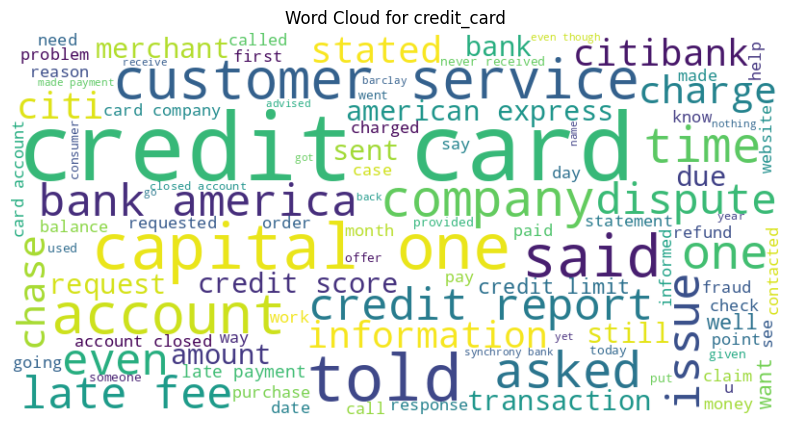

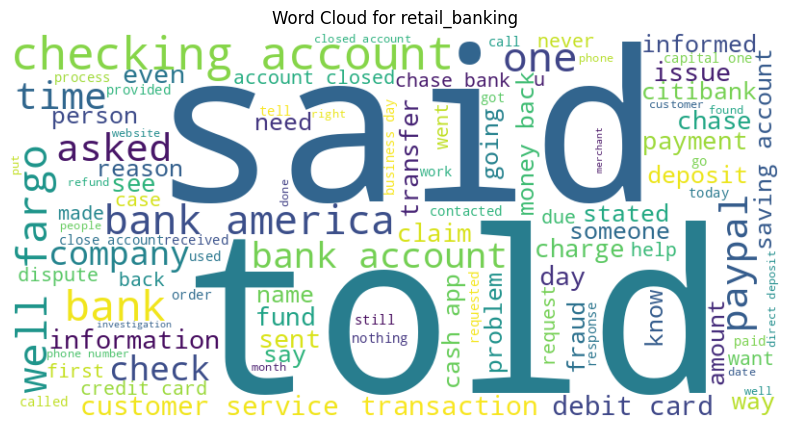

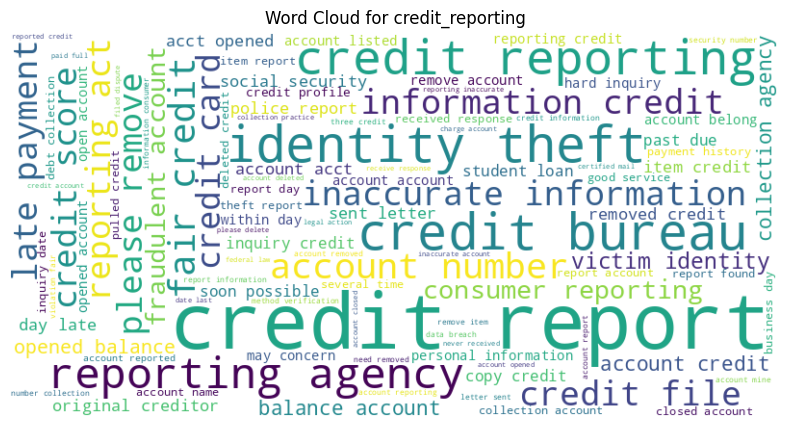

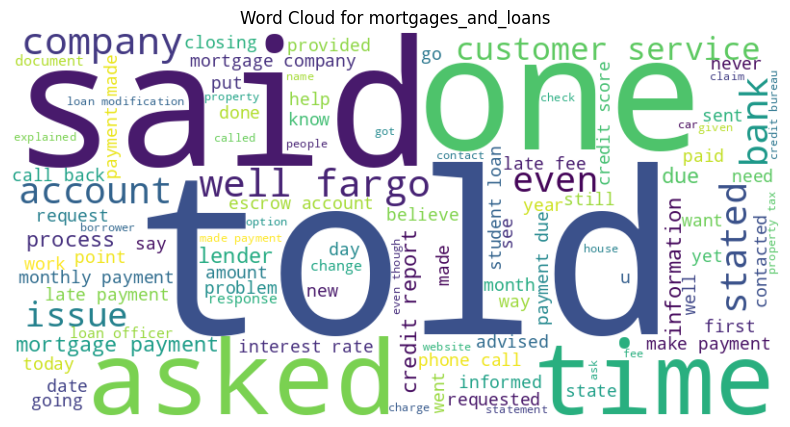

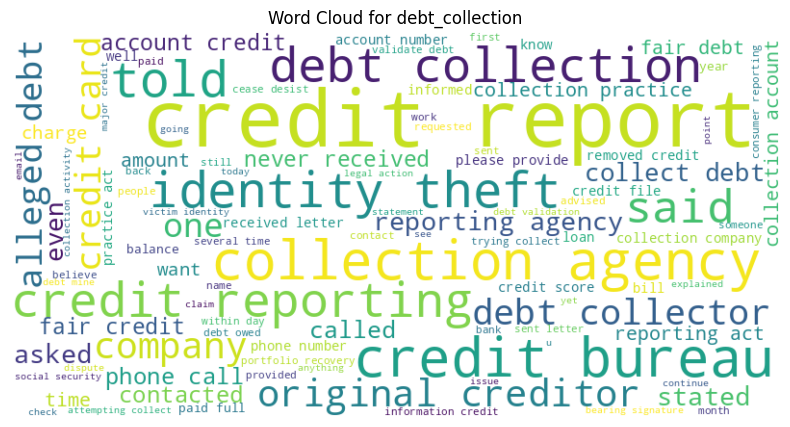

In [12]:
# Check the most common words in each class
# Function to generate word cloud for each product label
def generate_word_cloud(data, product_label):
    text = ' '.join(data['cleaned_narrative'][data['product'] == product_label])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {product_label}')
    plt.axis('off')
    plt.show()

# Get unique product labels
product_labels = df['product'].unique()

# Generate and display word cloud for each product label
for label in product_labels:
    generate_word_cloud(df, label)

Brief comments of the word clouds for each product label:

1. **Credit Card:** Key terms include "credit card," "charge," "account," "dispute," and "customer service," indicating frequent issues around charges, disputes, and account management with credit card providers.

2. **Retail Banking:** Words like "checking," "transaction," "account," "bank," and "debit" appear prominently, suggesting common complaints related to checking accounts, bank transactions, and debit cards.

3. **Credit Reporting:** Key words include "credit report," "bureau," "identity theft," and "inaccurate information," reflecting common issues with credit report accuracy, identity theft, and dealing with credit bureaus.

4. **Mortgages and Loans:** Words like "loan," "mortgage," "payment," "account," and "lender" dominate, pointing to frequent concerns with loan applications, mortgage payments, and interactions with lenders.

5. **Debt Collection:** Terms like "debt," "collection," "credit report," "creditor," and "identity theft" are prevalent, indicating issues around debt collection practices, credit reporting, and identity-related problems.

Each word cloud highlights specific terms associated with common issues for each product, showing that customer complaints are centered around distinct themes based on the product type.

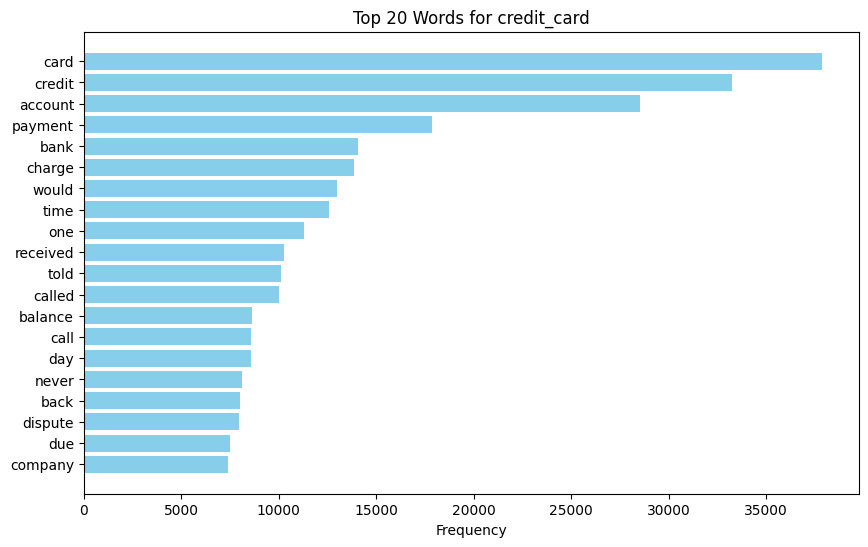

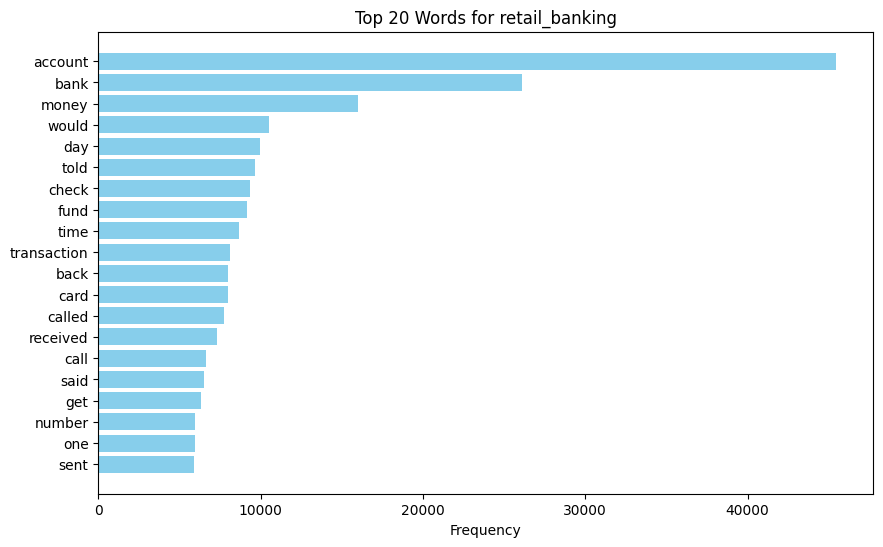

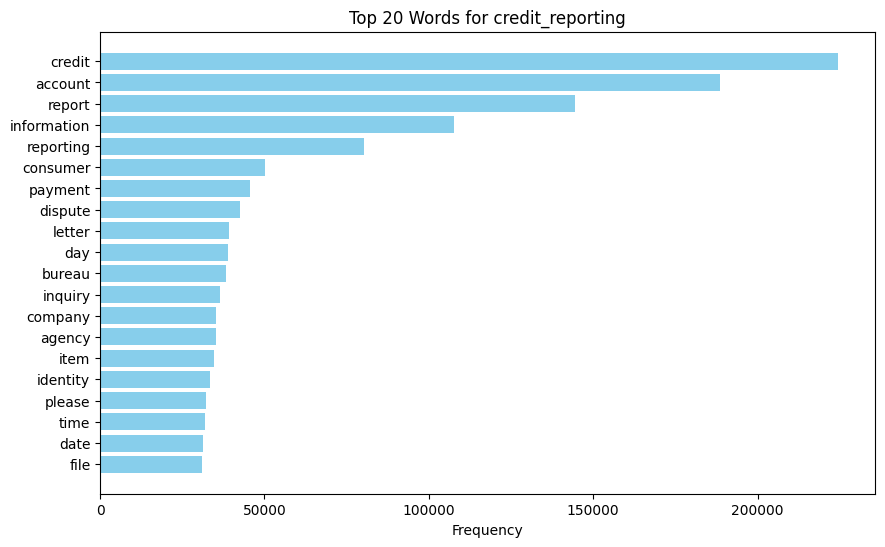

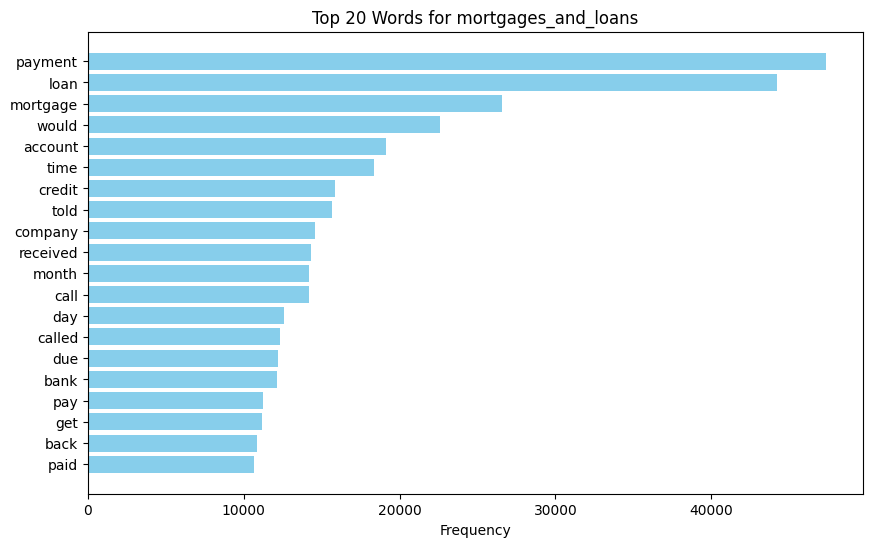

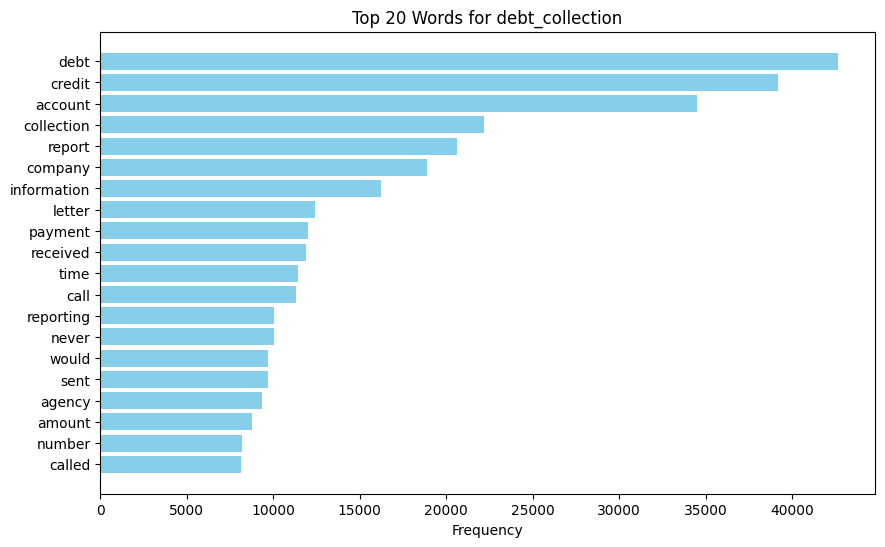

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Plot the top 20 words for each product label
def plot_top_words(data, product_label):
    # Filter data for the specific product label
    text = ' '.join(data['cleaned_narrative'][data['product'] == product_label])
    # Tokenize and count words
    word_counts = Counter(text.split())
    # Get the top 20 most common words
    top_words = word_counts.most_common(20)
    words, counts = zip(*top_words)

    # Plot the top 20 words
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top 20 Words for {product_label}')
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()

# Get unique product labels
product_labels = df['product'].unique()

# Generate and display the top 20 words for each product label
for label in product_labels:
    plot_top_words(df, label)

These visualizations provide an easy way to interpret and compare the key terms across product labels.

In [15]:
# Calculate text length
if 'text_length' not in df.columns:
    df['text_length'] = df['cleaned_narrative'].apply(len)

# Calculate word count
if 'number_of_words' not in df.columns:
    df['number_of_words'] = df['cleaned_narrative'].apply(lambda x: len(x.split()))

# Add text length column (character count for each narrative)
df['text_length'] = df['cleaned_narrative'].apply(len)

# Add word count column (number of words in each narrative)
df['number_of_words'] = df['cleaned_narrative'].apply(lambda x: len(x.split()))

# Display the relevant columns in the DataFrame
cleaned_df = df[['product', 'cleaned_narrative', 'text_length', 'number_of_words']]

# View the first few rows
cleaned_df.head()

,product,cleaned_narrative,text_length,number_of_words
0,credit_card,purchase order day shipping amount receive pro...,1705,230
1,credit_card,forwarded message date tue subject please inve...,904,132
2,retail_banking,forwarded message cc sent friday pdt subject f...,1230,173
3,credit_reporting,payment history missing credit report speciali...,903,131
4,credit_reporting,payment history missing credit report made mis...,851,123


Created a dataframe which includes the product, cleaned_narrative, text_length, and number_of_words columns for easy inspection.

In [16]:
# Ensure cleaned_df is a copy of the original DataFrame
cleaned_df = cleaned_df.copy()

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Encode the 'product' column and assign it to the new 'target' column
cleaned_df['target'] = label_encoder.fit_transform(cleaned_df['product'])

# Display the first few rows to verify the target encoding
cleaned_df.head()

,product,cleaned_narrative,text_length,number_of_words,target
0,credit_card,purchase order day shipping amount receive pro...,1705,230,0
1,credit_card,forwarded message date tue subject please inve...,904,132,0
2,retail_banking,forwarded message cc sent friday pdt subject f...,1230,173,4
3,credit_reporting,payment history missing credit report speciali...,903,131,1
4,credit_reporting,payment history missing credit report made mis...,851,123,1


Encoded the product column into numeric labels and assigned it to a new column called target.

In [17]:
# Create a dictionary to map each product category to its numeric label
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Mapping of product categories to numeric targets:")
for product, target in label_mapping.items():
    print(f"{product}: {target}")

Mapping of product categories to numeric targets:
credit_card: 0
credit_reporting: 1
debt_collection: 2
mortgages_and_loans: 3
retail_banking: 4


Mapped the product categories to the numeric targets.

## Data Transformation

In [18]:
# Separate the features (X) and target (y)
X = cleaned_df['cleaned_narrative']
y = cleaned_df['target']

# Perform the train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Print the shapes of the resulting splits
print("Training set shapes (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set shapes (X_test, y_test):", X_test.shape, y_test.shape)

Training set shapes (X_train, y_train): (129928,) (129928,)
Testing set shapes (X_test, y_test): (32483,) (32483,)


Split the training and testing sets, with class balance maintained across splits through the stratify parameter.

In [19]:
# Step 1: Apply TF-IDF transformation
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Step 2: Apply MinMax Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train_tfidf.toarray())
X_test_scaled = scaler.transform(X_test_tfidf.toarray())

# Print the shapes of the transformed features to verify
print("Scaled Training set shape:", X_train_scaled.shape)
print("Scaled Testing set shape:", X_test_scaled.shape)

Scaled Training set shape: (129928, 5000)
Scaled Testing set shape: (32483, 5000)


Vectorized and scaled the data to provide `X_train_scaled` and `X_test_scaled` transformed features that are ready for modeling

## Model Training

### Multinomial Naive Bayes

In [20]:
# Initialize and train the Multinomial Naive Bayes model
baseline_nb_model = MultinomialNB()
baseline_nb_model.fit(X_train_scaled, y_train)

#Make predictions on the test set
y_pred_base_nb = baseline_nb_model.predict(X_test_scaled)

# Create a list of class names in the correct order for target_names
# Sort `label_mapping` by numeric target to ensure correct order
target_names = [product for product, target in sorted(label_mapping.items(), key=lambda item: item[1])]

# Calculate accuracy and classification report with target names
accuracy_base_nb = accuracy_score(y_test, y_pred_base_nb)
report_base_nb = classification_report(y_test, y_pred_base_nb, target_names=target_names)

# Display the evaluation scores
print(f"Accuracy (Baseline MultinomialNB): {accuracy_base_nb}")
print("Classification Report (Baseline MultinomialNB):\n", report_base_nb)

Accuracy (Baseline MultinomialNB): 0.8231998276021304
Classification Report (Baseline MultinomialNB):
                      precision    recall  f1-score   support

        credit_card       0.66      0.74      0.70      3113
   credit_reporting       0.90      0.87      0.88     18235
    debt_collection       0.76      0.65      0.70      4630
mortgages_and_loans       0.71      0.86      0.78      3798
     retail_banking       0.80      0.86      0.83      2707

           accuracy                           0.82     32483
          macro avg       0.77      0.79      0.78     32483
       weighted avg       0.83      0.82      0.82     32483



The Multinomial Naive Bayes model achieved a **Macro F1-score of 0.78** and a **Weighted F1-score of 0.82**, indicating moderate overall performance with some variation across classes. The model performs well in identifying **credit_reporting** and **retail_banking** complaints, which have high F1-scores, but struggles with **credit_card** and **debt_collection** categories, where F1-scores are lower. This suggests that while the model is fairly accurate overall (reflected in the Weighted F1), it lacks consistency across all complaint types, as seen in the lower Macro F1.

### Support Vector Machine (SVM)

In [21]:
# Initialize and train the SVM model
baseline_svm_model = LinearSVC(max_iter=1000, random_state=42)
baseline_svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_base_svm = baseline_svm_model.predict(X_test_scaled)

# Create a list of class names in the correct order for target_names
# Sort `label_mapping` by numeric target to ensure correct order
target_names = [product for product, target in sorted(label_mapping.items(), key=lambda item: item[1])]

# Calculate accuracy and classification report with target names
accuracy_base_svm = accuracy_score(y_test, y_pred_base_svm)
report_base_svm = classification_report(y_test, y_pred_base_svm, target_names=target_names)

# Display the evaluation scores
print(f"Accuracy (Baseline SVM): {accuracy_base_svm}")
print("Classification Report (Baseline SVM):\n", report_base_svm)

Accuracy (Baseline SVM): 0.8679001323769356
Classification Report (Baseline SVM):
                      precision    recall  f1-score   support

        credit_card       0.78      0.76      0.77      3113
   credit_reporting       0.90      0.93      0.92     18235
    debt_collection       0.80      0.73      0.77      4630
mortgages_and_loans       0.85      0.81      0.83      3798
     retail_banking       0.85      0.86      0.85      2707

           accuracy                           0.87     32483
          macro avg       0.84      0.82      0.83     32483
       weighted avg       0.87      0.87      0.87     32483



The Support Vector Machine (SVM) model achieved a **Macro F1-score of 0.83** and a **Weighted F1-score of 0.87**, demonstrating stronger and more balanced performance across classes compared to the previous Multinomial Naive Bayes model. The SVM model performs especially well on **credit_reporting** with an F1-score of 0.92 and **retail_banking** with an F1-score of 0.85, indicating effective classification in these categories. While **credit_card** and **debt_collection** categories have lower F1-scores (0.77 each), they still show improvement over the Multinomial Naive Bayes model.

### Logistic Regression

In [22]:
# Initialize and train the Logistic Regression model
baseline_lr_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_lr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_base_lr = baseline_lr_model.predict(X_test_scaled)

# Create a list of class names in the correct order for target_names
# Sort `label_mapping` by numeric target to ensure correct order
target_names = [product for product, target in sorted(label_mapping.items(), key=lambda item: item[1])]

# Calculate accuracy and classification report with target names
accuracy_base_lr = accuracy_score(y_test, y_pred_base_lr)
report_base_lr = classification_report(y_test, y_pred_base_lr, target_names=target_names)

# Display the evaluation scores
print(f"Accuracy (Baseline Logistic Regression): {accuracy_base_lr}")
print("Classification Report (Baseline Logistic Regression):\n", report_base_lr)

Accuracy (Baseline Logistic Regression): 0.8732259951359173
Classification Report (Baseline Logistic Regression):
                      precision    recall  f1-score   support

        credit_card       0.79      0.78      0.78      3113
   credit_reporting       0.91      0.94      0.92     18235
    debt_collection       0.81      0.73      0.77      4630
mortgages_and_loans       0.85      0.82      0.84      3798
     retail_banking       0.87      0.87      0.87      2707

           accuracy                           0.87     32483
          macro avg       0.85      0.83      0.84     32483
       weighted avg       0.87      0.87      0.87     32483



The Logistic Regression model achieved a **Macro F1-score of 0.84** and a **Weighted F1-score of 0.87**, demonstrating solid and balanced performance across classes, similar to the SVM model. This model performs particularly well on **credit_reporting** with an F1-score of 0.92 and **retail_banking** with an F1-score of 0.87, indicating effective classification in these categories. The **credit_card** and **debt_collection** categories have lower F1-scores of 0.78 and 0.77, respectively, which are comparable to the results from the SVM model. Compared to SVM, Logistic Regression shows slightly higher F1-scores in **mortgages_and_loans** and **retail_banking**, but overall performance is very close.

### Random Forest

In [23]:
# Initialize and train the Random Forest model
baseline_rf_model = RandomForestClassifier(random_state=42)
baseline_rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_base_rf = baseline_rf_model.predict(X_test_scaled)

# Create a list of class names in the correct order for target_names
# Sort `label_mapping` by numeric target to ensure correct order
target_names = [product for product, target in sorted(label_mapping.items(), key=lambda item: item[1])]

# Calculate accuracy and classification report with target names
accuracy_base_rf = accuracy_score(y_test, y_pred_base_rf)
report_base_rf = classification_report(y_test, y_pred_base_rf, target_names=target_names)

# Display the evaluation scores
print(f"Accuracy (Baseline Random Forest): {accuracy_base_rf}")
print("Classification Report (Baseline Random Forest):\n", report_base_rf)

Accuracy (Baseline Random Forest): 0.8847704953360219
Classification Report (Baseline Random Forest):
                      precision    recall  f1-score   support

        credit_card       0.82      0.72      0.77      3113
   credit_reporting       0.90      0.97      0.93     18235
    debt_collection       0.89      0.73      0.80      4630
mortgages_and_loans       0.88      0.80      0.84      3798
     retail_banking       0.86      0.86      0.86      2707

           accuracy                           0.88     32483
          macro avg       0.87      0.82      0.84     32483
       weighted avg       0.88      0.88      0.88     32483



The Random Forest model achieved a **Macro F1-score of 0.84** and a **Weighted F1-score of 0.88**, indicating robust and balanced performance across all classes. It excels in **credit_reporting** with an F1-score of 0.93 and **retail_banking** with an F1-score of 0.86. The **credit_card** and **debt_collection** categories show moderate performance, with F1-scores of 0.77 and 0.80, respectively. Compared to previous models like SVM and Logistic Regression, Random Forest demonstrates a slightly higher Weighted F1-score, suggesting better performance on the more frequent classes. Its Macro F1-score remains comparable to those of Logistic Regression and SVM, indicating consistent classification across all categories. Random Forest is a slightly stronger model overall due to its improved accuracy and reliability on both major and minor classes.

## Evaluation

## Transformer Model

### Bidirectional Encoder Representations from Transformers (BERT)

In [ ]:
!pip install transformers torch datasets scikit-learn

In [ ]:
!pip install datasets

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
import numpy as np

# Load the BERT tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(set(y_train)))

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Prepare the datasets
train_dataset = Dataset.from_dict({"text": X_train, "label": y_train}).map(tokenize_function, batched=True)
test_dataset = Dataset.from_dict({"text": X_test, "label": y_test}).map(tokenize_function, batched=True)

train_dataset = train_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")

# Define the evaluation metric function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Define training arguments with early stopping
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    metric_for_best_model="f1",
    greater_is_better=True
)

# Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Stops if validation does not improve for 3 epochs
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/129928 [00:00<?, ? examples/s]

Map:   0%|          | 0/32483 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.478500,0.515624,0.873195,0.872113,0.873195,0.870575
2,0.631200,0.563464,0.873472,0.872295,0.873472,0.870580
3,0.193000,0.536766,0.877875,0.876433,0.877875,0.876300
4,0.543000,0.518722,0.877536,0.876623,0.877536,0.875503
5,0.272900,0.489602,0.881907,0.881155,0.881907,0.880887


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.478500,0.515624,0.873195,0.872113,0.873195,0.870575
2,0.631200,0.563464,0.873472,0.872295,0.873472,0.870580
3,0.193000,0.536766,0.877875,0.876433,0.877875,0.876300
4,0.543000,0.518722,0.877536,0.876623,0.877536,0.875503
5,0.272900,0.489602,0.881907,0.881155,0.881907,0.880887
6,0.469700,0.583751,0.819660,0.811559,0.819660,0.793822
7,0.352000,0.547390,0.886802,0.885681,0.886802,0.886068
8,0.512600,0.545489,0.887295,0.885797,0.887295,0.886137
9,0.351600,0.556751,0.889019,0.888627,0.889019,0.888743
10,0.225200,0.577121,0.888773,0.887743,0.888773,0.888078


Evaluation Results: {'eval_loss': 0.5567514896392822, 'eval_accuracy': 0.8890188714096604, 'eval_precision': 0.8886272511800908, 'eval_recall': 0.8890188714096604, 'eval_f1': 0.8887425872105229, 'eval_runtime': 216.4612, 'eval_samples_per_second': 150.064, 'eval_steps_per_second': 18.761, 'epoch': 10.0}


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions on the test set
predictions = trainer.predict(test_dataset)

# Extract the predicted labels and true labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Create a list of class names in the correct order for target_names
# Sort `label_mapping` by numeric target to ensure correct order
target_names = [product for product, target in sorted(label_mapping.items(), key=lambda item: item[1])]

# Generate and print the classification report
report = classification_report(labels, preds, target_names=target_names)
print("Classification Report:\n", report)

Classification Report:
                      precision    recall  f1-score   support

        credit_card       0.81      0.79      0.80      3113
   credit_reporting       0.93      0.94      0.93     18235
    debt_collection       0.81      0.80      0.81      4630
mortgages_and_loans       0.86      0.84      0.85      3798
     retail_banking       0.86      0.90      0.88      2707

           accuracy                           0.89     32483
          macro avg       0.85      0.85      0.85     32483
       weighted avg       0.89      0.89      0.89     32483



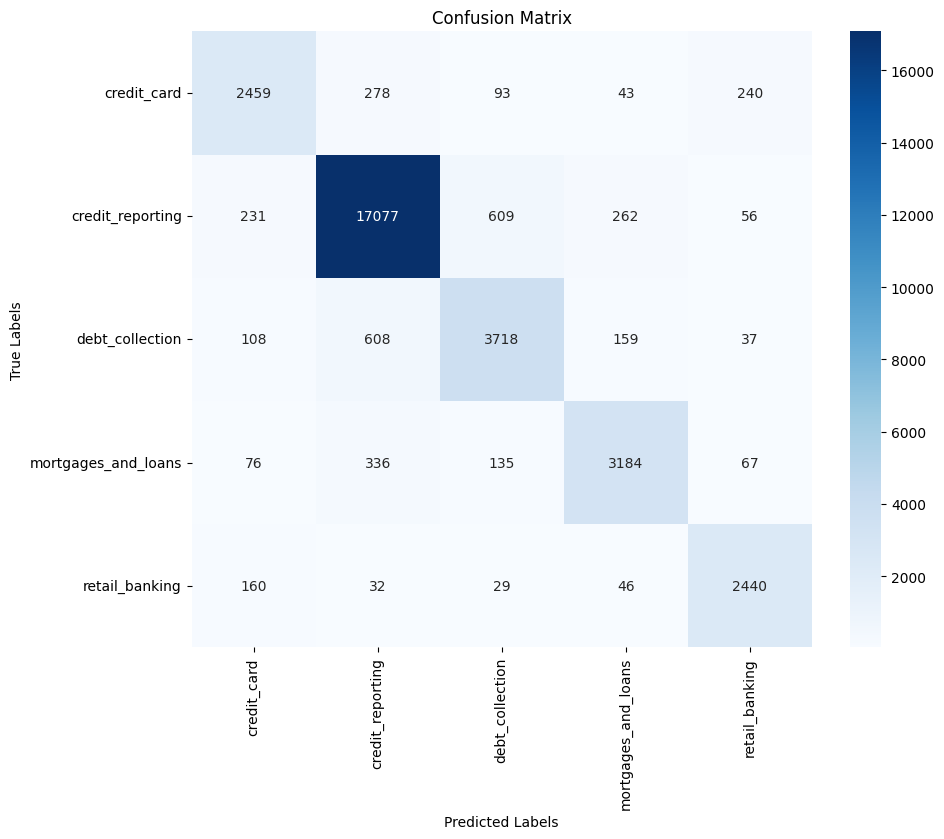

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

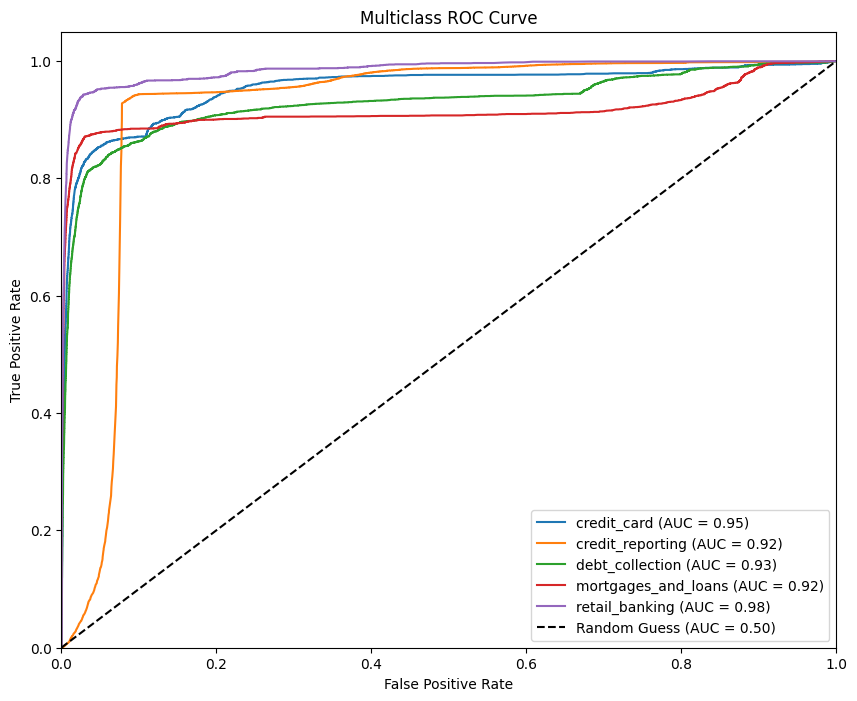

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import label_binarize

# AUC-ROC Curve
# Binarize the labels for multiclass ROC
labels_binarized = label_binarize(labels, classes=np.arange(len(target_names)))
preds_proba = predictions.predictions  # Use the raw prediction logits

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(target_names):
    fpr, tpr, _ = roc_curve(labels_binarized[:, i], preds_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Define the directory where the model and tokenizer are saved
output_dir = "/content/drive/MyDrive/saved_bert_model"

# Save the model
trainer.save_model(output_dir)

# Save the tokenizer as well (important for loading the model later)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /content/drive/MyDrive/saved_bert_model


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the tokenizer and model
loaded_tokenizer = BertTokenizer.from_pretrained(output_dir)
loaded_model = BertForSequenceClassification.from_pretrained(output_dir)

print("Model and tokenizer loaded successfully!")

Model and tokenizer loaded successfully!


In [ ]:
# Define the prediction function
def classify_text(text):
    # Tokenize the input text
    inputs = loaded_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)

    # Move inputs to the same device as the model (CPU or GPU)
    inputs = {key: value.to(loaded_model.device) for key, value in inputs.items()}

    # Perform inference
    with torch.no_grad():
        outputs = loaded_model(**inputs)

    # Get the predicted label (argmax over logits)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()

    return predicted_label

# Define a mapping for labels to class names
label_map = {
    0: "credit_card",
    1: "retail_banking",
    2: "credit_reporting",
    3: "mortgages_and_loans",
    4: "debt_collection"
}

# Classify new examples
new_texts = [
    "I am very unhappy with the service on my credit card.",
    "My mortgage application was declined without any valid reason.",
    "I have been getting spam calls from a loan company.",
    "The bank charged me extra fees without prior notice.",
    "The insurance company is not processing my claim."
]

# Run classification and print results with class names
for text in new_texts:
    label_id = classify_text(text)
    label_name = label_map[label_id]
    print(f"Text: {text}\nPredicted Category: {label_name}\n")

Text: I am very unhappy with the service on my credit card.
Predicted Category: credit_card

Text: My mortgage application was declined without any valid reason.
Predicted Category: mortgages_and_loans

Text: I have been getting spam calls from a loan company.
Predicted Category: mortgages_and_loans

Text: The bank charged me extra fees without prior notice.
Predicted Category: debt_collection

Text: The insurance company is not processing my claim.
Predicted Category: credit_reporting

